In [1]:
import jax.numpy as jnp
import jax
from jax import vmap, value_and_grad, jit, random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

In [2]:
from jax import config
config.update("jax_debug_nans", True)
config.update("jax_debug_infs", True)

In [3]:
x, y = make_moons(n_samples = (1000, 1200),
                  shuffle = True,
                  noise = 0.15,
                  random_state = 56)
y = y.reshape(-1, 1)

In [4]:
x.shape, y.shape

((2200, 2), (2200, 1))

In [5]:
x[:5], y[:5]

(array([[ 0.45690662,  0.78097945],
        [-0.596873  ,  0.60647025],
        [ 0.59184507,  0.55023653],
        [ 0.86591914, -0.17583813],
        [-0.84143517,  0.64557038]]),
 array([[0],
        [0],
        [0],
        [1],
        [0]], dtype=int64))

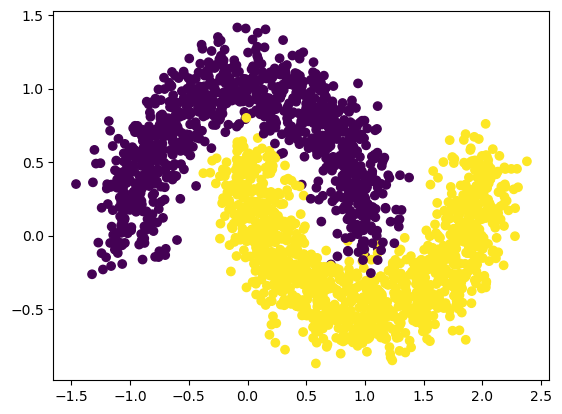

In [6]:
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.show();

In [7]:
def init_params(layer_sizes, key):
    params = []
    keys = random.split(key, num = len(layer_sizes))
    
    for in_features, out_features, key in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        wkey, bkey = random.split(key)
        w = random.normal(key, (in_features, out_features)) * (1/in_features)**0.5
        b = random.normal(key, (out_features,)) * (1/in_features)**0.5
        params.append((w, b))
        
    return params

In [8]:
layer_sizes = [2, 25, 25, 1]
key = random.PRNGKey(56)
params = init_params(layer_sizes, key)

In [9]:
jax.tree_map(lambda x: x.shape, params)

[((2, 25), (25,)), ((25, 25), (25,)), ((25, 1), (1,))]

In [10]:
def predict(params, x):
    activation = x
    for w, b in params[:-1]:
        yh = jnp.dot(activation, w) + b
        activation = jax.nn.softplus(yh)
    return jax.nn.sigmoid(jnp.dot(activation, params[-1][0]) + params[-1][1])

In [11]:
def loss(params, x, y):
    yhat = predict(params, x)
    log_yhat = jnp.log(jnp.where(yhat > 0., yhat, 1e-10))
    log_1myhat = jnp.log(jnp.where(1-yhat > 0., 1-yhat, 1e-10))
    return -jnp.mean(jnp.where(y == 1, log_yhat, log_1myhat))

In [12]:
loss(params, x, y)

Array(0.7543669, dtype=float32)

In [13]:
@jit
def update(params, x, y, lr = 0.01):
    loss_value, gradients = value_and_grad(loss)(params, x, y)
    params = jax.tree_map(lambda p, g: p - lr * g, params, gradients)
    
    return params, loss_value

In [14]:
train_size = int(len(x)*0.8)
xtr, ytr = x[:train_size], y[:train_size]
xte, yte = x[train_size:], y[train_size:]

In [15]:
for e in range(10000):
    lr = 0.01 if e > 5000 else 0.005 if e > 7500 else 0.001
    params, loss_value = update(params, xtr, ytr)
    
    if e % 1000 == 0:
        print(loss_value)

0.7545821
0.29772013
0.2595953
0.25537768
0.25352824
0.25174752
0.2497328
0.24724728
0.24399313
0.23958267


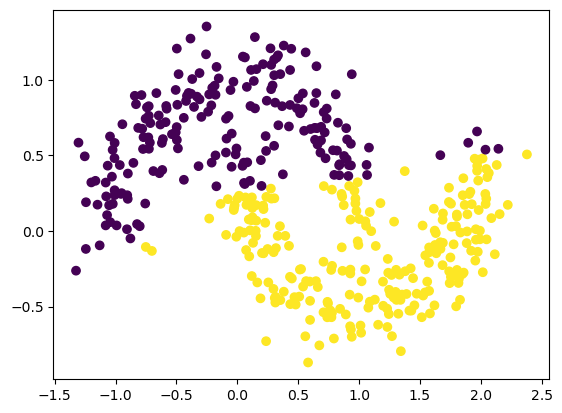

In [16]:
predictions = predict(params, xte)
predictions = jnp.where(predictions > 0.5, 1, 0)
plt.scatter(xte[:, 0], xte[:, 1], c=predictions)
plt.show();